Elaboration of data output from SQL database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re
import numpy as np

In [78]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')
query_cost_op_tot = "SELECT * FROM cost_op_tot"  
cost_op_tot = pd.read_sql_query(query_cost_op_tot, conn)
query_cost_period = "SELECT * FROM cost_period"
cost_period = pd.read_sql_query(query_cost_period, conn)
query_active_techs = "SELECT * FROM active_techs"
active_techs = pd.read_sql_query(query_active_techs, conn)
query_cost_cap = "SELECT * FROM cost_cap"
cost_cap= pd.read_sql_query(query_cost_cap, conn)
query_cap_tot = "SELECT * FROM cap_tot"
cap_tot= pd.read_sql_query(query_cap_tot, conn)
query_cost_inv = "SELECT * FROM cost_inv"
cost_inv= pd.read_sql_query(query_cost_inv, conn)
query_new_units= "SELECT * FROM new_units"
new_units= pd.read_sql_query(query_new_units, conn)

#For scalar values
query_disc_frac = "SELECT * FROM disc_frac"
disc_frac_pd= pd.read_sql_query(query_disc_frac, conn)
disc_frac=disc_frac_pd['values'].iloc[0]
query_insulation = "SELECT * FROM insulation"
insulation_pd= pd.read_sql_query(query_insulation, conn)
insulation=insulation_pd['values'].iloc[0]
query_TI_cost = "SELECT * FROM TI_cost"
TI_cost_pd= pd.read_sql_query(query_TI_cost, conn)
TI_cost=TI_cost_pd['values'].iloc[0]

conn.close()

In [79]:
activity_costs=sum(cost_op_tot['values'])
periodic_costs=sum(cost_period['values']*active_techs['values'])+sum(cost_cap['values']*cap_tot['values'])
bill_one_year=activity_costs+periodic_costs
discount=sum(disc_frac ** x for x in range(1, 11))
operation_costs_discounted=bill_one_year*discount
investment_costs=sum(cost_inv['values']*new_units['values'])
NPC=operation_costs_discounted+investment_costs

print('The NPC is over 10 years is: ', round(NPC,2),'€')
print('For each year the operative expenses are:', round(bill_one_year,2), '€')
print('The initial investment cost is:', round(investment_costs,2),'€')


The NPC is over 10 years is:  7538.97 €
For each year the operative expenses are: 635.26 €
The initial investment cost is: 2450.0 €


In [80]:
investment_cost_breakdown=pd.DataFrame()
investment_cost_breakdown['t_names']=cost_inv['t_names']
investment_cost_breakdown['values']=cost_inv['values']*new_units['values']
print('Technology expansion investment:\n', investment_cost_breakdown[investment_cost_breakdown['values']!=0])

Technology expansion investment:
            t_names  values
3               HP  2000.0
4       Storage HW   200.0
6  Induction stove   250.0


Graphs

In [81]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')
query_Y = "SELECT * FROM Y"  
Y = pd.read_sql_query(query_Y, conn)
query_Q = "SELECT * FROM Q"
Q = pd.read_sql_query(query_Q, conn)
query_X = "SELECT * FROM X"
X = pd.read_sql_query(query_X, conn)
query_Xt = "SELECT * FROM X_t"
Xt = pd.read_sql_query(query_Xt, conn)

conn.close()

In [8]:
seasons = ['wi', 'mc', 'mw', 'su']
season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

In [82]:
#Isolate peak hour
peak_Y= Y[Y['th_names'] == 'h_peak']
Y=Y[Y['th_names'] != 'h_peak']
peak_Q= Q[Q['th_names'] == 'h_peak']
Q=Q[Q['th_names'] != 'h_peak']
peak_X=X[X['th_names'] == 'h_peak']
X=X[X['th_names'] != 'h_peak']
peak_Xt=Xt[Xt['th_names'] == 'h_peak']
Xt=Xt[Xt['th_names'] != 'h_peak']

In [83]:
#Temporal features
for db in [Y,Q,X,Xt]:
    db.index=range(len(db))
    db.loc[:,'season']=db['th_names'].str[4:6]
    db['hour'] = db['th_names'].str[1:3].astype(int)
    db['day'] = db['th_names'].str[-2:].astype(int)
    db['time'] = (db['day'] - 1) * 24 + db['hour']

Electricity

In [84]:
PV_prod=X[X['a_names']=='PV']
PV_sell=X[X['a_names']=='National Grid export']
Battery=X[X['a_names']=='Storing EE']
Q_EE=Q[Q['n_names']=='EE']
PV_prod.index = Q_EE.index = PV_sell.index =Battery.index = range(len(PV_prod))

Batt_charge=Battery.copy()
Batt_charge['values'] = Batt_charge['values'].apply(lambda x: 0 if x > 0 else x)

PV_consump=PV_prod.copy()
PV_consump['values']=PV_prod['values'].to_numpy()-PV_sell['values'].to_numpy()+Battery['values'].to_numpy()
PV_consump['values'] = PV_consump['values'].where(PV_prod['values']>0, 0) 
PV_consump['values'] = PV_prod['values'].where((PV_prod['values']<Q_EE['values']) & (Battery['values']>=0), PV_consump['values'])

Batt_discharge=Battery.copy()
Batt_discharge['values'] = Batt_discharge['values'].to_numpy()-PV_sell['values'].to_numpy()
Batt_discharge['values'] = Batt_discharge['values'].apply(lambda x: 0 if x < 0 else x)

EE_grid=X[X['a_names']=='National Grid import']

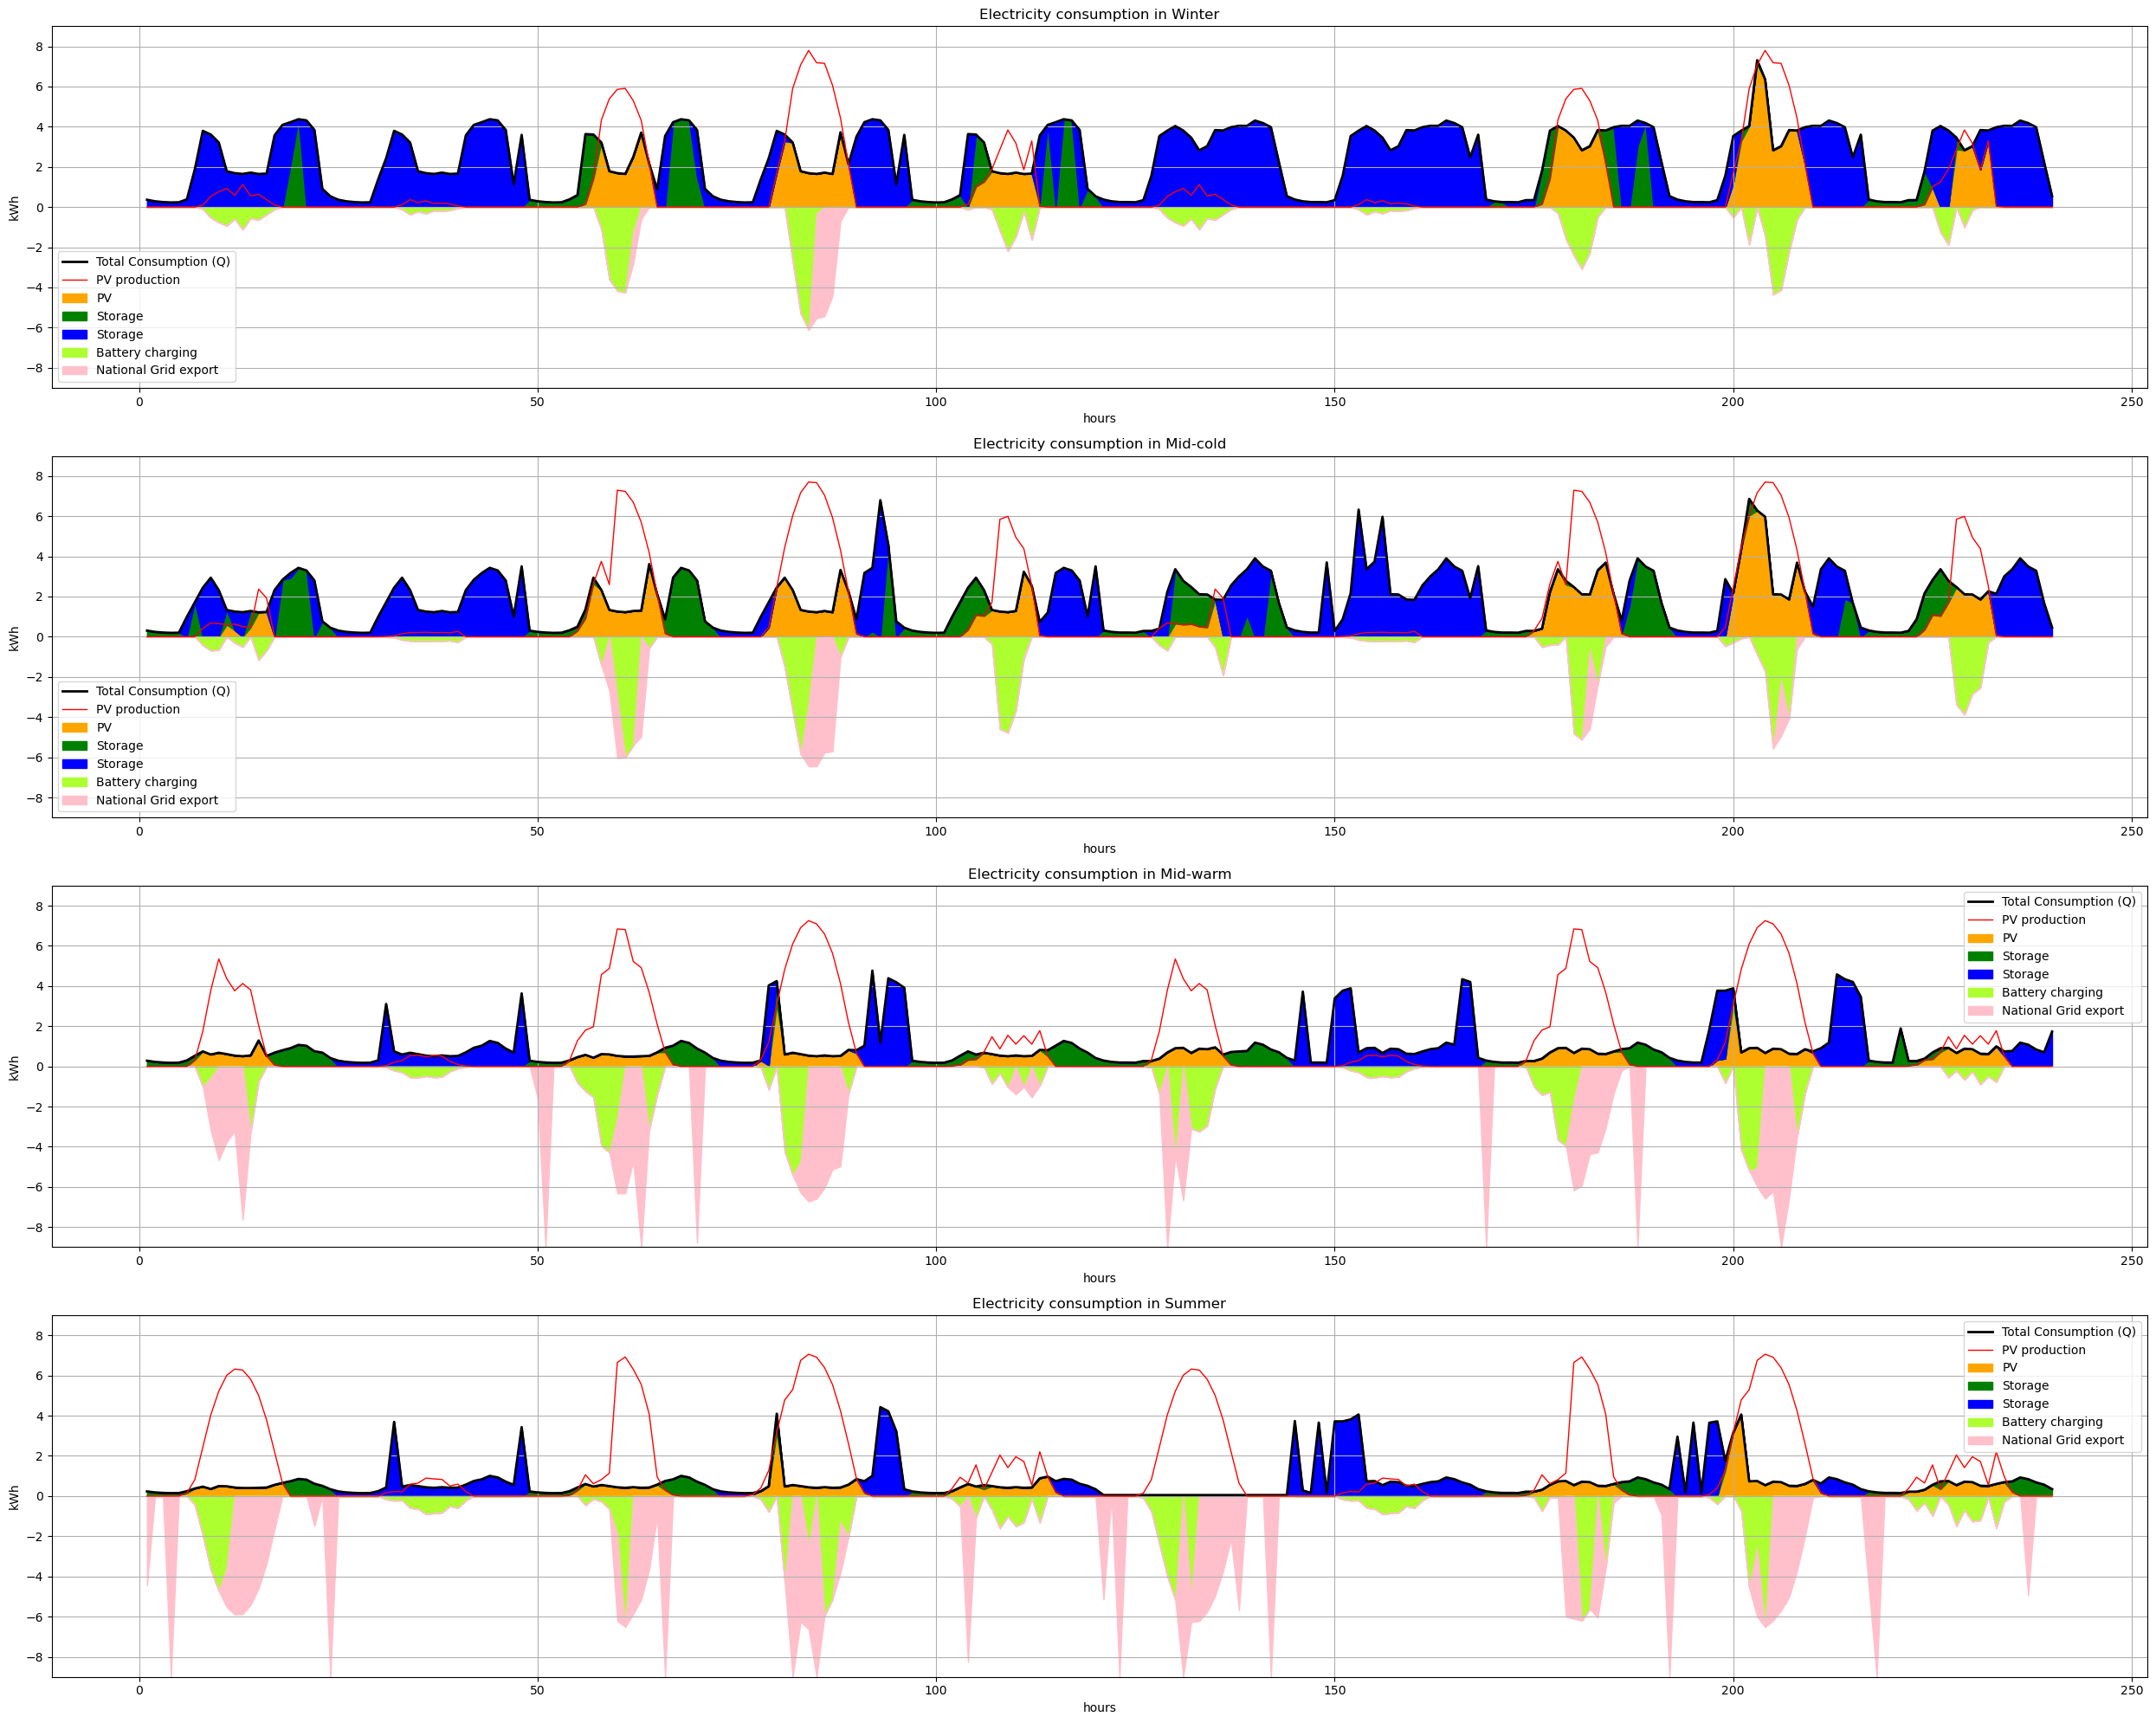

In [85]:
#Electricity production
plt.figure(figsize=(25, 20))
Time=range(1,241)
Time_ind=pd.Index(range(1, 241))
for i, season in enumerate(seasons, 1):
    Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
    PV_prod_season = PV_prod[PV_prod['season'] == season]['values']
    PV_consump_season = PV_consump[PV_consump['season'] == season]['values']
    PV_consump_season.index=Time_ind
    Batt_discharge_season = Batt_discharge[Batt_discharge['season'] == season]['values']
    Batt_discharge_season.index=Time_ind
    EE_grid_season = EE_grid[EE_grid['season'] == season]['values']
    EE_grid_season.index=Time_ind

    Batt_charge_season = Batt_charge[Batt_charge['season'] == season]['values']
    Batt_charge_season.index=Time_ind
    PV_sell_season=-PV_sell[PV_sell['season'] == season]['values']
    PV_sell_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, PV_prod_season, color='red', linewidth=1, label='PV production')
    plt.fill_between(Time,0,PV_consump_season, color='orange', label='PV')
    plt.fill_between(Time,PV_consump_season,PV_consump_season+Batt_discharge_season, color='green', label='Storage')
    plt.fill_between(Time,PV_consump_season+Batt_discharge_season,PV_consump_season+Batt_discharge_season+EE_grid_season, color='blue', label='Storage')
    #negative
    plt.fill_between(Time,0,Batt_charge_season, color='greenyellow', label='Battery charging')
    plt.fill_between(Time,Batt_charge_season,Batt_charge_season+PV_sell_season, color='pink', label='National Grid export')
    plt.xlabel('hours')
    plt.ylabel('kWh')
    plt.ylim(-9,9)
    plt.title(f'Electricity consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Hot water

In [123]:
HP_prod=Xt[Xt['t_names']=='HP']
HW_storage=X[X['a_names']=='Storing HW']
#Q_HW=Q[Q['n_names']=='Hot water']
HP_prod.index = Q_HW.index = HW_storage.index =range(len(HP_prod))

stor_charge=HW_storage.copy()
stor_charge['values'] = stor_charge['values'].apply(lambda x: 0 if x > 0 else x)
stor_discharge=HW_storage.copy()
stor_discharge['values'] = stor_discharge['values'].apply(lambda x: 0 if x < 0 else x)

HP_use=HP_prod.copy()
HP_use['values']=HP_prod['values'].to_numpy()+stor_charge['values'].to_numpy()

HW_for_heating=Q[Q['n_names']=='Heat']
HW_for_heating['values']=HW_for_heating['values']*1.2

/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_79719/593288631.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HW_for_heating['values']=HW_for_heating['values']*1.2


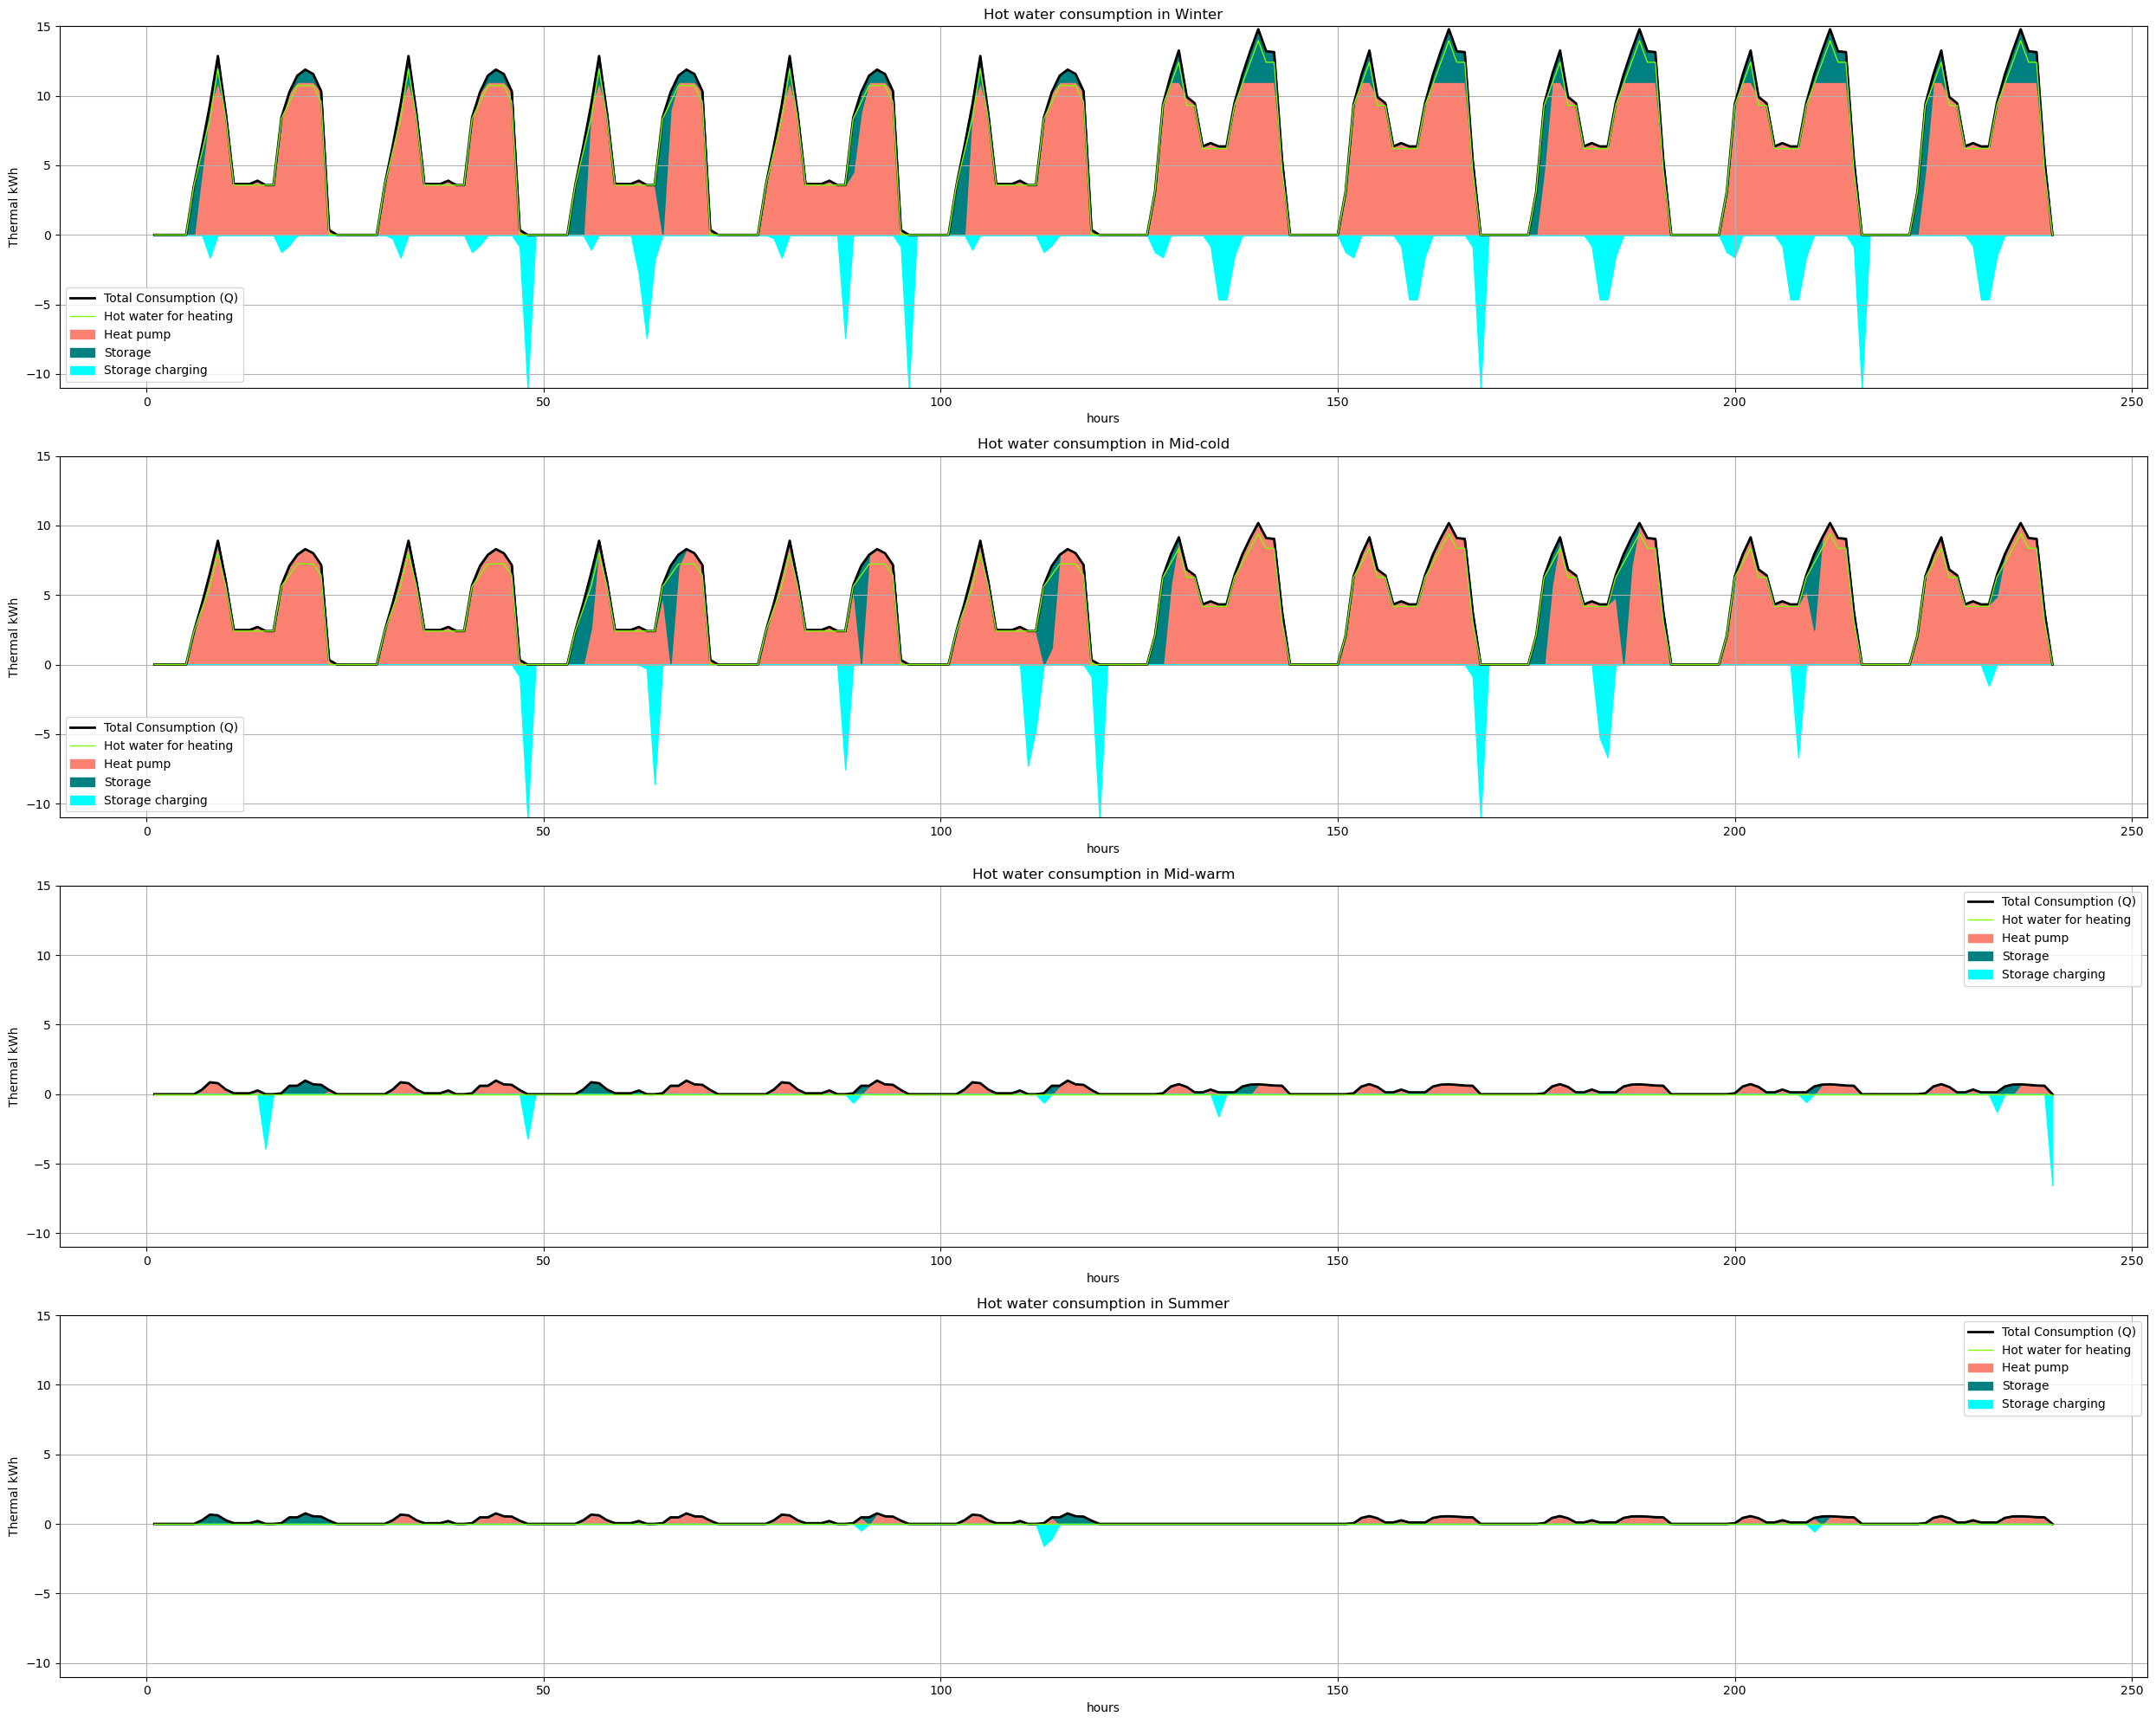

In [127]:
#Hot water production
plt.figure(figsize=(25, 20))

for i, season in enumerate(seasons, 1):
    Q_HW_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Hot water')]['values']
    HP_use_season = HP_use[HP_use['season'] == season]['values']
    stor_charge_season = stor_charge[stor_charge['season'] == season]['values']
    #PV_consump_season.index=Time_ind
    stor_discharge_season = stor_discharge[stor_discharge['season'] == season]['values']
    HW_heating_season = HW_for_heating[HW_for_heating['season'] == season]['values']

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_HW_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, HW_heating_season, color='lawngreen', linewidth=1, label='Hot water for heating')
    plt.fill_between(Time,0,HP_use_season, color='salmon', label='Heat pump')
    plt.fill_between(Time,HP_use_season,HP_use_season+stor_discharge_season, color='teal', label='Storage')
    #negative
    plt.fill_between(Time,0,stor_charge_season, color='cyan', label='Storage charging')
    plt.xlabel('hours')
    plt.ylabel('Thermal kWh')
    plt.ylim(-11,15)
    plt.title(f'Hot water consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Heating?

Cooking

In [93]:
Gas_stove=X[X['a_names']=='Gas stove cooking']
Ind_stove=X[X['a_names']=='Induction stove cooking']
Gas_stove.index = Ind_stove.index =range(len(Gas_stove))

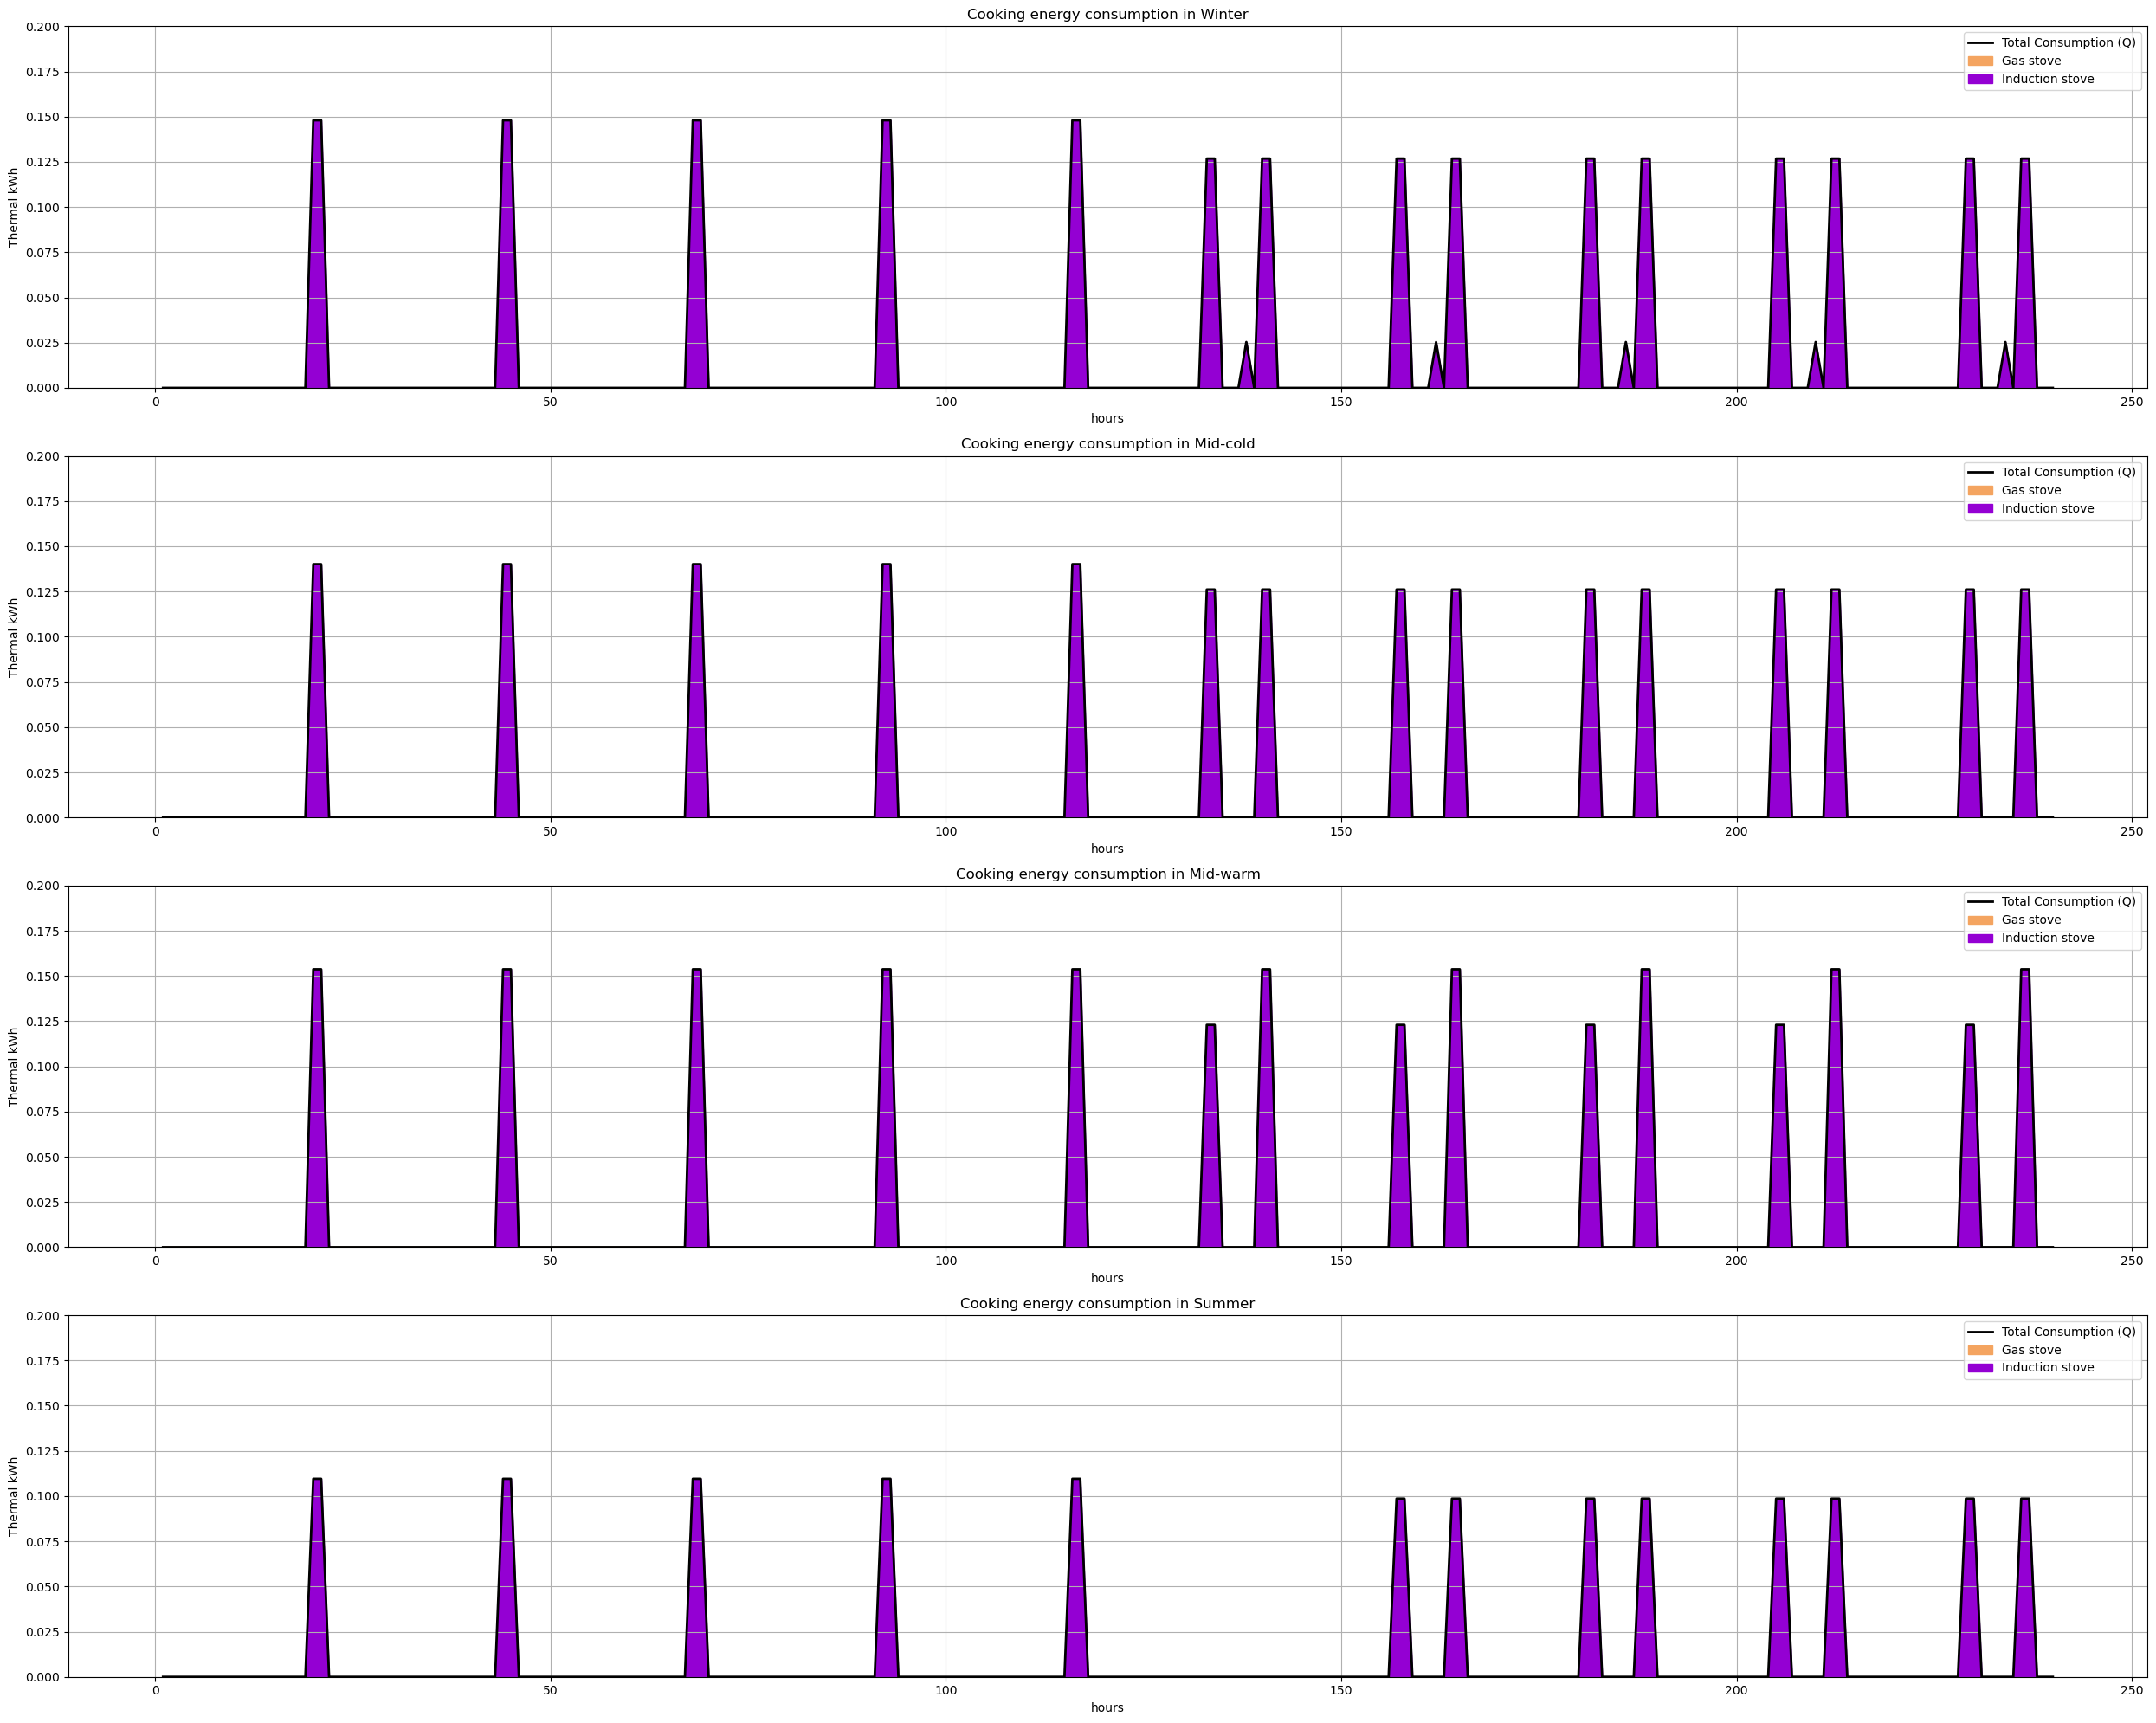

In [98]:
#Cooking consumption
plt.figure(figsize=(25, 20))

for i, season in enumerate(seasons, 1):
    Q_cook_season = Q[(Q['season'] == season) & (Q['n_names'] == 'Cooking')]['values']
    Gas_stove_season = Gas_stove[Gas_stove['season'] == season]['values']
    Ind_stove_season = Ind_stove[Ind_stove['season'] == season]['values']
    #PV_consump_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_cook_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.fill_between(Time,0,Gas_stove_season, color='sandybrown', label='Gas stove')
    plt.fill_between(Time,0,Ind_stove_season, color='darkviolet', label='Induction stove')
    #negative
    plt.xlabel('hours')
    plt.ylabel('Thermal kWh')
    plt.ylim(0,0.2)
    plt.title(f'Cooking energy consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Transport

In [108]:
BEV_urban=X[X['a_names']=='BEV urban']
BEV_mot=X[X['a_names']=='BEV motorway']
Charge_home=X[X['a_names']=='BEV charging home']
Charge_street1=X[X['a_names']=='BEV charging1 street']
Charge_street2=X[X['a_names']=='BEV charging2 street']
BEV_urban.index = BEV_mot.index =Charge_home.index=Charge_street1.index=Charge_street2.index = range(len(BEV_urban))

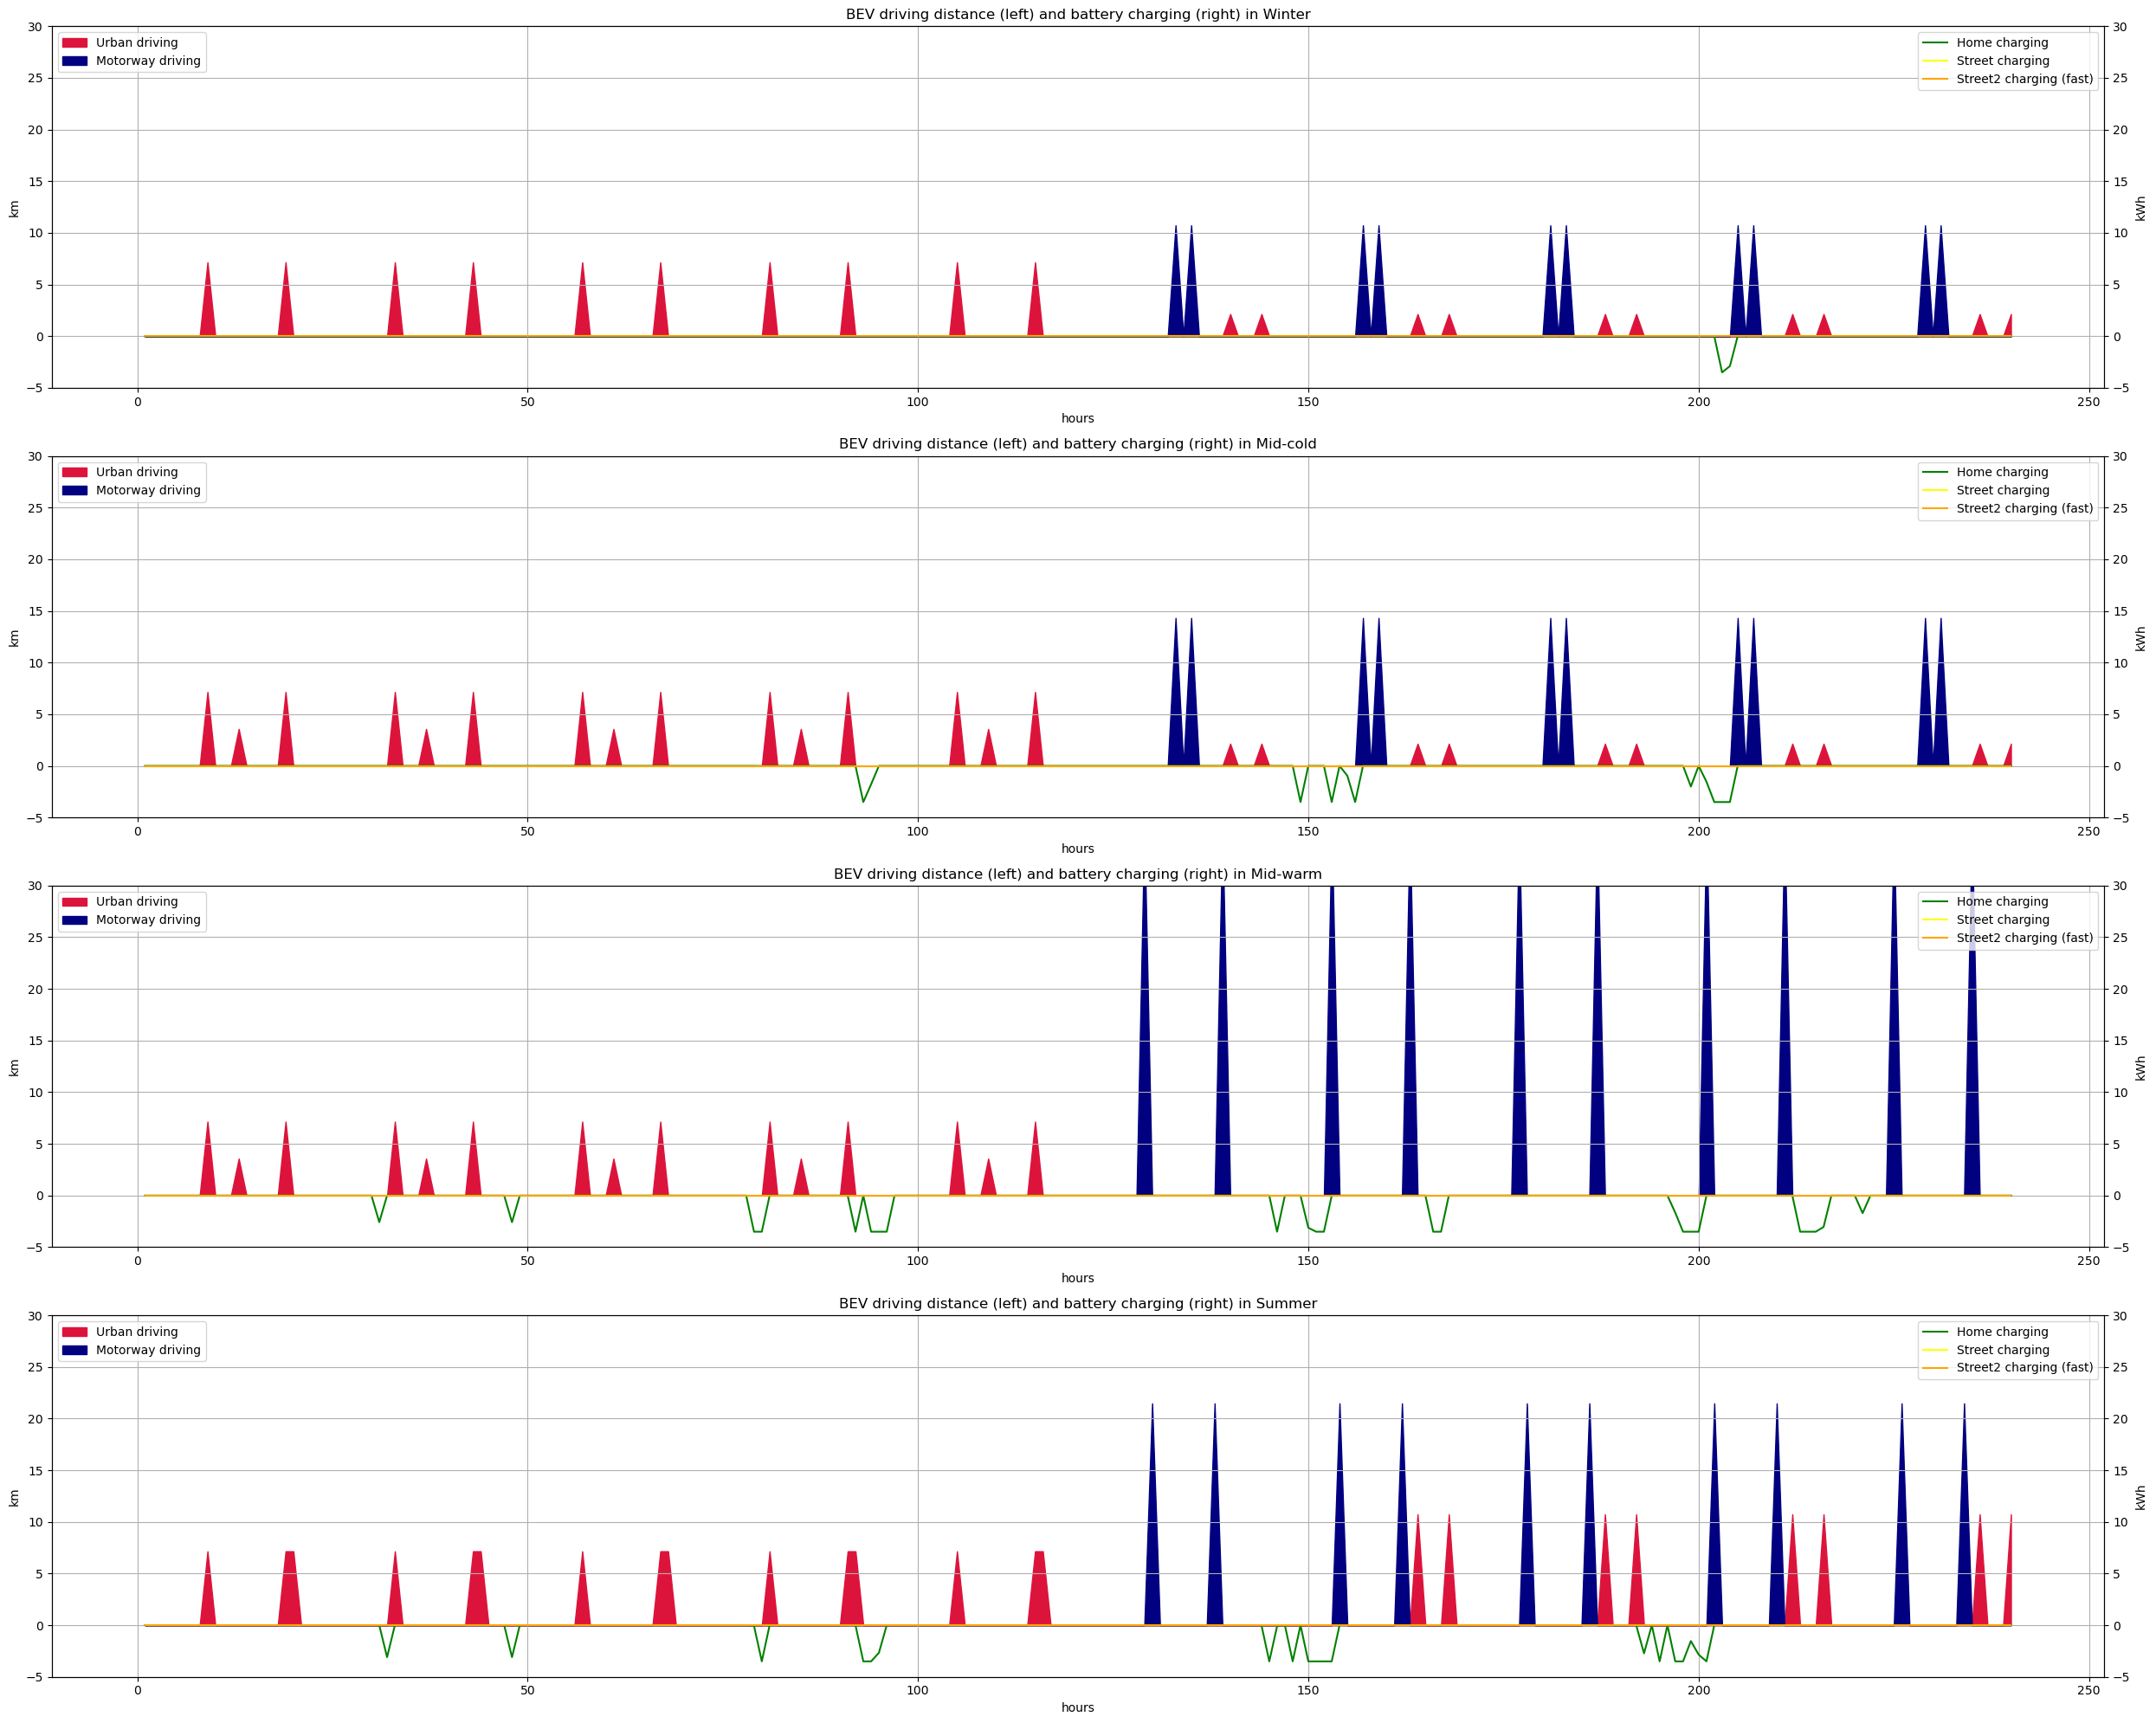

In [121]:
plt.figure(figsize=(25, 20))

for i, season in enumerate(seasons, 1):
    BEV_urban_season = BEV_urban[BEV_urban['season'] == season]['values']
    BEV_mot_season = BEV_mot[BEV_mot['season'] == season]['values']
    Charge_home_season = -Charge_home[Charge_home['season'] == season]['values']
    Charge_street1_season = -Charge_street1[Charge_street1['season'] == season]['values']
    Charge_street2_season = -Charge_street2[Charge_street2['season'] == season]['values']

    ax1=plt.subplot(4, 1, i)
    ax1.fill_between(Time,0,BEV_urban_season, color='crimson', label='Urban driving')   
    ax1.fill_between(Time,0,BEV_mot_season, color='navy', label='Motorway driving')
    ax1.set_xlabel('hours')
    ax1.set_ylabel('km')
    ax1.set_ylim(-5,30)
    ax1.set_title(f'BEV driving distance (left) and battery charging (right) in {season_names[season]}')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    #Right axis for charge
    ax2 = ax1.twinx()
    ax2.plot(Time,Charge_home_season, color='green', label='Home charging')
    ax2.plot(Time,Charge_street1_season, color='yellow', label='Street charging')
    ax2.plot(Time,Charge_street2_season, color='orange', label='Street2 charging (fast)')
    ax2.set_ylabel('kWh')
    ax2.set_ylim(-5,30)
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Peak hour analysis

In [156]:
#Under development
peak=pd.DataFrame()
peak['tech']=peak_Q['n_names']
peak['Q']=np.zeros(len(peak['tech']))
for tech in peak['tech']:
    peak.loc[peak['tech']==tech,'Q']=peak_Q[peak_Q['n_names']==tech]['values'].values[0]

peak['Y']=np.zeros(len(peak['tech']))
for tech in peak['tech']:
    peak.loc[peak['tech']==tech,'Y']=peak_Y[peak_Y['n_names']==tech]['values'].values[0]

peak['StorageEE']=np.zeros(len(peak['tech']))
peak.loc[peak['tech']=='EE','StorageEE']=peak_X[peak_X['a_names']=='Storing EE']['values'].values[0]

#peak['StorageHW']=np.zeros(len(peak['tech']))...

Export from database to excel

In [ ]:
Y_summer=Y[Y['season']=='su']
Y_summer.to_excel('excel database/Y_summer.xlsx')
Q_summer=Q[Q['season']=='su']
Q_summer.to_excel('excel database/Q_summer.xlsx')
X_summer=X[X['season']=='su']
X_summer.to_excel('excel database/X_summer.xlsx')

In [ ]:
#Codice potenzialmente utile
plt.figure(figsize=(25, 10))
Time=range(1, 961)

plt.plot(Time, Q_EE['values'], color='black', linewidth=2, label='Total Consumption (Q)')
plt.plot(Time, PV_prod['values'], color='green', linewidth=2, label='PV Production')
plt.plot(Time, PV_consump['values'], color='orange', linewidth=2, label='PV Consumption')
plt.ylim(-9,9)
plt.title(f'Electricity consumption in {season_names[season]}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()